In [1]:
import pandas as pd
import numpy as np
import fancyimpute
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_regression,f_regression
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import Imputer,PolynomialFeatures,PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')

C:\Users\Dailey\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class transform1():
    def __init__(self):
        pass
    def fit(self,df,col_null=0.7):
        try:
            self.target=df['Comb Unrd Adj FE - Conventional Fuel']
        except:
            self.target=df['target']
        nan_col=np.array(np.mean(pd.isnull(df),axis=0)>col_null)#remove the column that have over 30% null values
        df=df[df.columns[~nan_col]]
        #df=df.drop('Model Year',axis=1)
        for i in df.columns:
            try:
                condition=[('EPA' in i),('FE' in i),('Guzzler' in i),('CO2' in i),('costs' in i),\
                           ('GHG' in i),('MPG' in i),('Cost' in i),('Smog' in i),('Calc' in i)\
                           ]
                if np.any(condition):
                    df=df.drop(i,axis=1)
            except:
                continue
        self.df=df
        self.columns=list(self.df.columns)
    def transform(self,df_trans):
        target=df_trans['Comb Unrd Adj FE - Conventional Fuel']
        df=df_trans[self.columns]
        df['target']=target
        #remove the records that are mostly zero
        nan_row=np.array(np.sum(pd.isnull(df),axis=1)>20)
        df=df.iloc[[i for i in df.index if ~nan_row[i]]]
        return df

## Total dataset

In [3]:
data_frame=[]
df_2015=pd.read_csv('2015 FE Guide-for DOE-Mobility Ventures only-OK to release-no-sales-4-27-2017Mercedesforpublic.csv')
data_frame.append(df_2015)
df_2016=pd.read_csv('2016 FE Guide for DOE-OK to release-no-sales-4-27-2017Mercedesforpublic.csv')
data_frame.append(df_2016)
df_2017=pd.read_csv('2017 FE Guide for DOE-release dates before 9-20-2017-no sales-9-19-2017MercedesCadillacforpublic.csv')
data_frame.append(df_2017)
df_2018=pd.read_csv('2018 FE Guide for DOE-release dates before 2-17-2018-no-sales-2-15-2018public.csv')
data_frame.append(df_2018)
df=pd.concat(data_frame,ignore_index=True)

# Task1

## visualize the dataset

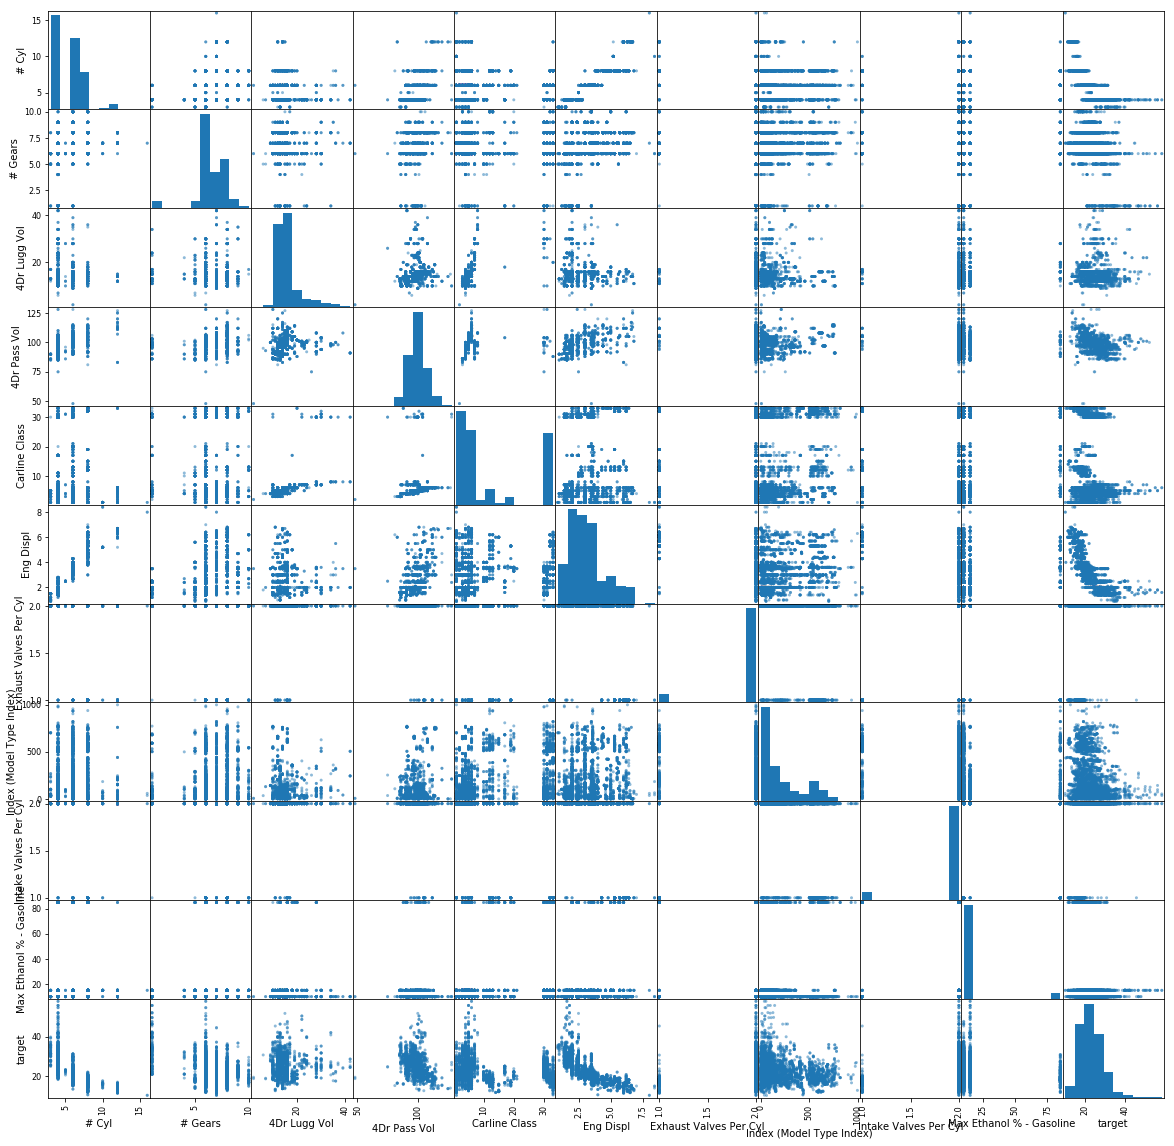

In [4]:
trans1=transform1()
trans1.fit(df)
df1=trans1.transform(df)
fig,ax=plt.subplots(figsize=(20,20))
pd.plotting.scatter_matrix(df1.drop('Model Year',axis=1),ax=ax)
plt.show()

## Features Used for regression & Description

In [5]:
for i in df1.columns:
    if i!='target' and i!='Model Year':
        print(i)

# Cyl
# Gears
4Dr Lugg Vol
4Dr Pass Vol
Air Aspir Method
Air Aspiration Method Desc
Camless Valvetrain (Y or N)
Car/Truck Category - Cash for Clunkers Bill.
Carline
Carline Class
Carline Class Desc
Comments - Mfr Eng Cnfg
Cyl Deact?
Descriptor - Model Type (40 Char or less)
Division
Drive Desc
Drive Sys
Eng Displ
Exhaust Valves Per Cyl
Fuel Metering Sys Cd
Fuel Metering Sys Desc
Fuel Unit - Conventional Fuel
Fuel Unit Desc - Conventional Fuel
Fuel Usage  - Conventional Fuel
Fuel Usage Desc - Conventional Fuel
Index (Model Type Index)
Intake Valves Per Cyl
Label Recalc?
Lockup Torque Converter
Max Ethanol % - Gasoline
Mfr Name
Oil Viscosity
Police/Emerg?
Release Date
Stop/Start System (Engine Management System)  Description
Stop/Start System (Engine Management System) Code
Suppressed?
Trans
Trans Creeper Gear
Trans Desc
Transmission
Unique Label?
Var Valve Lift Desc
Var Valve Lift?
Var Valve Timing Desc
Var Valve Timing?
Verify Mfr Cd


* The features used are shown above. In this task, we want to remove any feature that has mathematical repationship with `Comb Unrd Adj FE - Conventional Fuel` and remain only those manufactuer measurements, so we remove the features containing 'EPA', 'FE', 'Guzzler', 'CO2', 'GHG', 'MPG', 'Cost', 'Smog' or 'Calc'. We also dropped the columns with more than 70% of items being null. The rest of the features are used for regression. 

* The main goal is to predict 2018 data and evaluate the model using iid assumption. 
 First, we used the data from 2015-2017 to train the Ridge Regression Model. We applied `GridSearchCV` to choose the best parameter `alpha`(0.7848). Then we used that trained model to predict the data from 2018 and got the test score (The test score for 2018 FE is 0.92766). 
 Second, we gathered the total data set and used the iid assumption. We used `train_test_split` to get training and testing data. We used the best `alpha` calculated before as the parameter and trained the Ridge Regression using that training data, and tested that model using test data (The test score for test set is 0.94386).

* In this task, we used `pandas.get_dummies` to encode categorical variables and used `Imputer` to do the imputation using feature mean. After that, we used the Ridge model to train. The detailed information is as follows.

## Prediction of 2018 based on 2015-2017 data

In [6]:
df1_d=pd.get_dummies(df1)

In [7]:
df_train=df1_d[df1['Model Year']!=2018].drop('target',axis=1)
train_target=df1_d[df1['Model Year']!=2018]['target']
df_test=df1_d[df1['Model Year']==2018].drop('target',axis=1)
test_target=df1_d[df1['Model Year']==2018]['target']

In [8]:
param_range=np.logspace(-2,2,20)
param_grid={'alpha':param_range}
grid1=GridSearchCV(Ridge(),param_grid=param_grid,cv=5)
pipe_pred1=make_pipeline(Imputer(strategy='mean'),MinMaxScaler())
pipe_pred1.fit(df_train)
df_train=pipe_pred1.transform(df_train)
df_test=pipe_pred1.transform(df_test)
grid1.fit(df_train,train_target)
print('Best parameter')
print(grid1.best_params_)

Best parameter
{'alpha': 0.7847599703514611}


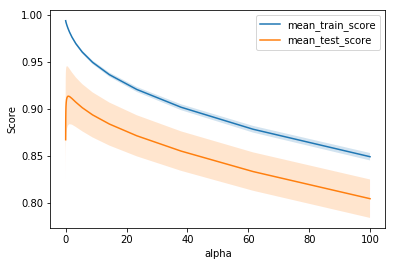

In [9]:
fig,ax=plt.subplots()
ax.plot(param_range,grid1.cv_results_['mean_train_score'],label='mean_train_score')
ax.fill_between(param_range,grid1.cv_results_['mean_train_score']-grid1.cv_results_['std_train_score'],\
                            grid1.cv_results_['mean_train_score']+grid1.cv_results_['std_train_score'],alpha=0.2)
ax.plot(param_range,grid1.cv_results_['mean_test_score'],label='mean_test_score')
ax.fill_between(param_range,grid1.cv_results_['mean_test_score']-grid1.cv_results_['std_test_score'],\
                            grid1.cv_results_['mean_test_score']+grid1.cv_results_['std_test_score'],alpha=0.2)
ax.set_xlabel('alpha')
ax.set_ylabel('Score')
plt.legend()
plt.show()

**We used `GridSearchCV` to find the best `alpha`**

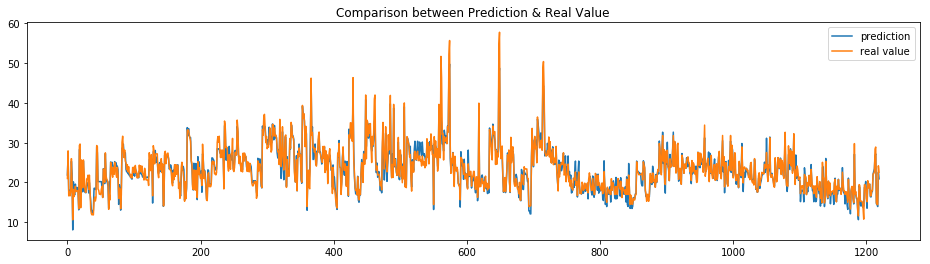

In [10]:
alpha1=grid1.best_params_['alpha']
pred1=grid1.predict(df_test)
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(range(df_test.shape[0]),pred1,label='prediction')
ax.plot(range(df_test.shape[0]),test_target,label='real value')
plt.title('Comparison between Prediction & Real Value')
plt.legend()
plt.show()

In [11]:
score1=grid1.score(df_test,test_target)
print('The score for predicting 2018 FE data is %.5f'%score1)

The score for predicting 2018 FE data is 0.92766


## Train and Test with iid assumption

In [12]:
df1_d=pd.get_dummies(df1)

In [13]:
y=df1_d['target']
x=df1_d.drop('target',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=5,test_size=0.4)

ridge=Ridge(alpha=alpha1)
pipe1=make_pipeline(Imputer(strategy='mean'),MinMaxScaler(),ridge)
pipe1.fit(x_train,y_train)
score=pipe1.score(x_test,y_test)
print("The test score with iid assumtion is %.5f"%score)

The test score with iid assumtion is 0.94386


# Task2

In [14]:
columns=['# Cyl', '# Gears','4Dr Lugg Vol','4Dr Pass Vol','Carline Class', 'Eng Displ', 'Exhaust Valves Per Cyl',\
        'Index (Model Type Index)','Intake Valves Per Cyl', 'Max Ethanol % - Gasoline']
df_tmp=df1[columns]
mice=fancyimpute.MICE(verbose=0)
df_imp2=mice.complete(df_tmp)
df_imp2=pd.DataFrame(df_imp2,columns=columns)
pt=PowerTransformer(method='box-cox',standardize=False)

## visualize the transformed data

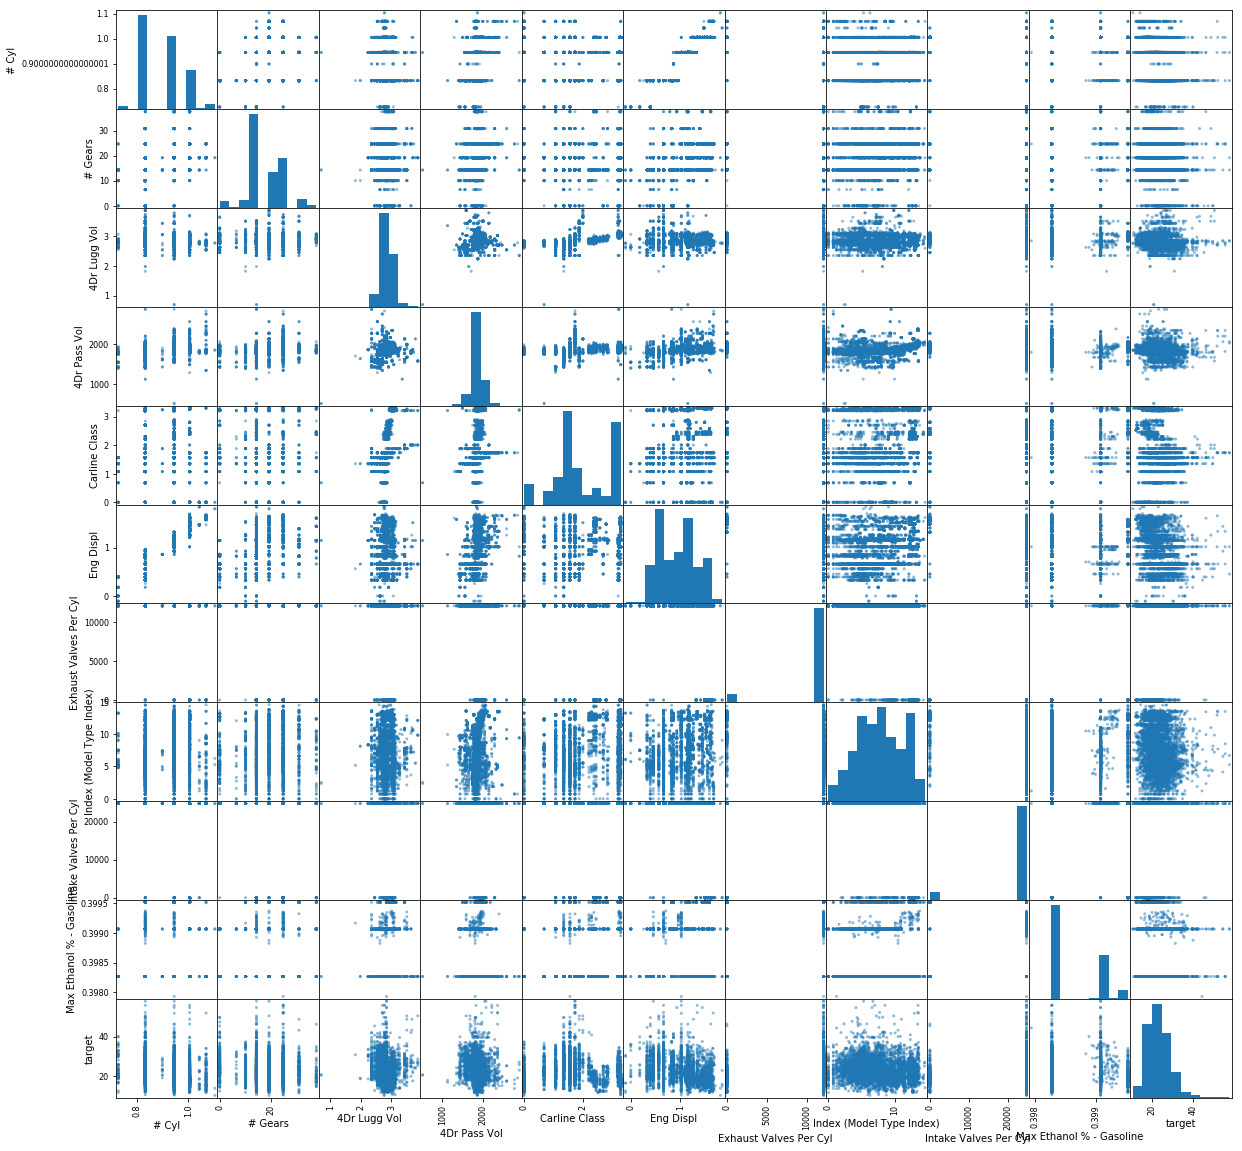

In [15]:
fig,ax=plt.subplots(figsize=(20,20))
df2_tmp=pd.DataFrame(pt.fit_transform(df_imp2),columns=columns)
df2_tmp['target']=df1['target']
pd.plotting.scatter_matrix(df2_tmp,ax=ax)
plt.show()

## Features Used for regression & Description

* In this task, we used the features selected in task 1 and did some more processing. 
 First, for those numerical features, we applied `PowerTransformer` ('Cox-Box' method) to eliminate the skewness of the distribution for each one as shown in the scatter matrix. Then, we used `MinMaxScaler` to scale the data and applied `PolynomialFeatures` to do the polynomial transformation to expand the numerical features to second degree. 
 
* The main goal is to predict 2018 data and evaluate the model using iid assumption. 
 First, we used the data from 2015-2017 to train the Ridge Regression Model. We applied `GridSearchCV` to choose the best parameter `alpha`(1.0625). Then we used that trained model to predict the data from 2018 and got the test score (The test score for 2018 FE is 0.93546). 
 Second, we gathered the total data set and used the iid assumption. We used `train_test_split` to get training and testing data. We used the best `alpha` calculated before as the parameter and trained the Ridge Regression using that training data, and tested that model using test data (The test score for test set is 0.95079).
 
* The random states for `train_test_split` are the same. In task1, the score for 2018 prediction was 0.92766 and now it is 0.93546; the score with iid assumption was 0.94386 in task1 and now it is 0.95079. We can see that the scores are improved

* In this task, we used `pandas.get_dummies` to encode categorical variables and used `fancyimpute` to do the imputation. We wanted to apply polynomial transformation to all features and also believed it could have worked better in that way, but it turned out that the transformed data would be too big to handle, so we only focused on numerical features. After useing `PowerTransformer`, we first scaled the data, then applied polynomial transformation in the hope that higer degree would be penalized. After that, we used the Ridge model to train. The detailed information is as follows.

## Prediction of 2018 based on 2015-2017 data

In [16]:
df1=df1.reset_index().drop('index',axis=1)
df_imp2=df_imp2.reset_index().drop('index',axis=1)

In [17]:
df2_total=pd.get_dummies(pd.concat([df_imp2,df1.drop(columns,axis=1)],axis=1))
df2_total=df2_total.take(df2_total.index[~np.isnan(df2_total['target'])])
df2_train=df2_total[df2_total['Model Year']!=2018].drop('target',axis=1).reset_index()
df2_train.drop('index',axis=1,inplace=True)
train_target2=df2_total[df2_total['Model Year']!=2018]['target']
df2_test=df2_total[df2_total['Model Year']==2018].drop('target',axis=1).reset_index()
df2_test.drop('index',axis=1,inplace=True)
test_target2=df2_total[df2_total['Model Year']==2018]['target']

In [18]:
pipe_trans2=make_pipeline(Imputer(strategy='mean'),PowerTransformer(standardize=False),MinMaxScaler(),\
                          PolynomialFeatures(include_bias=True))
df2_train=pd.concat([pd.DataFrame(pipe_trans2.fit_transform(df2_train[columns])),df2_train.drop(columns,axis=1)],axis=1)
df2_test=pd.concat([pd.DataFrame(pipe_trans2.transform(df2_test[columns])),df2_test.drop(columns,axis=1)],axis=1)

In [19]:
param_range2=np.logspace(-2,1.5,20)
param_grid2={'alpha':param_range2}
grid2=GridSearchCV(Ridge(),param_grid=param_grid2,cv=5)
grid2.fit(df2_train,train_target2)
print('Best parameter')
print(grid2.best_params_)

Best parameter
{'alpha': 1.062467830894041}


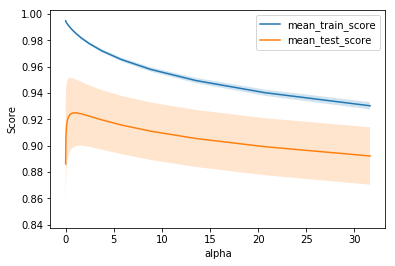

In [20]:
fig,ax=plt.subplots()
ax.plot(param_range2,grid2.cv_results_['mean_train_score'],label='mean_train_score')
ax.fill_between(param_range2,grid2.cv_results_['mean_train_score']-grid2.cv_results_['std_train_score'],\
                grid2.cv_results_['mean_train_score']+grid2.cv_results_['std_train_score'],alpha=0.2)
ax.plot(param_range2,grid2.cv_results_['mean_test_score'],label='mean_test_score')
ax.fill_between(param_range2,grid2.cv_results_['mean_test_score']-grid2.cv_results_['std_test_score'],\
                grid2.cv_results_['mean_test_score']+grid2.cv_results_['std_test_score'],alpha=0.2)
ax.set_xlabel('alpha')
ax.set_ylabel('Score')
plt.legend()
plt.show()

**We used `GridSearchCV` to find the best `alpha`**

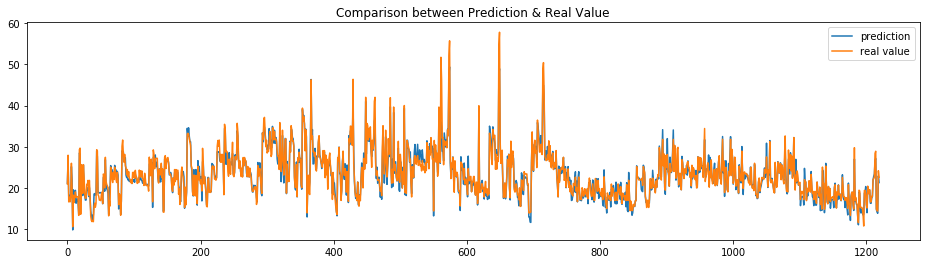

In [21]:
alpha2=grid2.best_params_['alpha']
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(range(df2_test.shape[0]),grid2.predict(df2_test),label='prediction')
ax.plot(range(df2_test.shape[0]),test_target2,label='real value')
plt.title('Comparison between Prediction & Real Value')
plt.legend()
plt.show()

In [22]:
score2=grid2.score(df2_test,test_target2)
print('The score for predicting 2018 FE data is %.5f'%score2)

The score for predicting 2018 FE data is 0.93554


## Train and test with iid assumtion

In [23]:
random_state=5
test_size=0.4
x_tr1,x_te1,y_train,y_test=train_test_split(df_imp2,df1['target'],random_state=random_state,test_size=test_size)
x_tr2,x_te2,_,_=train_test_split(pd.get_dummies(df1.drop(columns,axis=1)).drop('target',axis=1),df1['target'],random_state=random_state,test_size=test_size)

In [24]:
pipe2=make_pipeline(Imputer(strategy='mean'),PowerTransformer(standardize=False),MinMaxScaler(),\
                    PolynomialFeatures(include_bias=True,degree=2))
X_tr1=pipe2.fit_transform(x_tr1)
X_te1=pipe2.transform(x_te1)
X_test=pd.concat([pd.DataFrame(X_te1).reset_index(),x_te2.reset_index()],axis=1).drop('index',axis=1)
X_train=pd.concat([pd.DataFrame(X_tr1).reset_index(),x_tr2.reset_index()],axis=1).drop('index',axis=1)
ridge=Ridge(alpha=alpha2)
ridge.fit(X_train,y_train)
score=ridge.score(X_test,y_test)
print("The test score with iid assumption is %.5f"%score)

The test score with iid assumption is 0.95026


# Task3

## Parameter Selection & Result Description

* In this task, we used `xgboost` to train the data. The features and preprocessing process are the same as task1. 
 First, we used the data from 2015-2017 to train the Xgboost Model. We applied `GridSearchCV` to choose the best parameter `max_depth` and `n_estimator`. Then we used that trained model to predict the data from 2018 and got the test score (The test score for 2018 FE is 0.97259). 
 Second, we gathered the total data set and used the iid assumption. We used `train_test_split` to get training and testing data. We used the best `max_depth`(15) and `n_estimator`(2500) calculated before as the parameter and trained the Xgboost using that training data, and tested that model using test data (The test score for test set is 0.97966).
 
* The random states for `train_test_split` are the same with previos tasks. In task2, the score for 2018 prediction was 0.93546 and now it is 0.97259; the score with iid assumption was0.95079 in task2 and now it is 0.97966. We can see that the scores are much improved.

* It can be seen from the heatmap that although the `max_depth` and `n_estimator` have reached 25 and 2500, the model has not yet overfitted along the `n_estimator` direction, which means there is still room for improvement. But due to limited time and resouces, these are the best results that we can get. The results are as follows.

## Prediction of 2018 based on 2015-2017 data

In [5]:
df3_train=df1_d[df1['Model Year']!=2018].drop('target',axis=1)
train_target3=df1_d[df1['Model Year']!=2018]['target']
df3_test=df1_d[df1['Model Year']==2018].drop('target',axis=1)
test_target3=df1_d[df1['Model Year']==2018]['target']

In [6]:
grid_param={'max_depth':[5,10,15,20,25],'n_estimators':[500,1000,1500,2000,2500]}
#grid_param={'max_depth':[1],'n_estimators':[2]}
xgb0=XGBRegressor(learning_rate=0.01,n_jobs=5)
grid3=GridSearchCV(xgb0,param_grid=grid_param,cv=5, return_train_score=True)
grid3.fit(df3_train,train_target3)
print('Best parameters are:')
print(grid3.best_params_)

Best parameters are:
{'max_depth': 15, 'n_estimators': 2500}


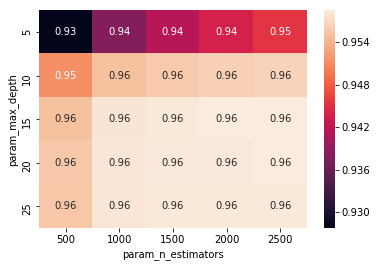

In [7]:
param_map=pd.pivot_table(pd.DataFrame(grid3.cv_results_),'mean_test_score','param_max_depth','param_n_estimators')
sns.heatmap(param_map,annot=True)
plt.show()

In [8]:
score3=grid3.score(df3_test,test_target3)
print("The score for predicting 2018 FE data is %.5f"%score3)

The score for predicting 2018 FE data is 0.97259


## Train and Test

In [9]:
max_depth,n_estimators=grid3.best_params_['max_depth'],grid3.best_params_['n_estimators']
X_train,X_test,y_train,y_test=train_test_split(df1_d.drop('target',axis=1),df1_d['target'],random_state=5,test_size=0.4)
xgb=XGBRegressor(learning_rate=0.01,max_depth=max_depth,n_estimators=n_estimators,n_jobs=5).fit(X_train,y_train)

In [10]:
score3=xgb.score(X_test,y_test)
print('The score is %.5f'%score3)

The score is 0.97966


# Task4

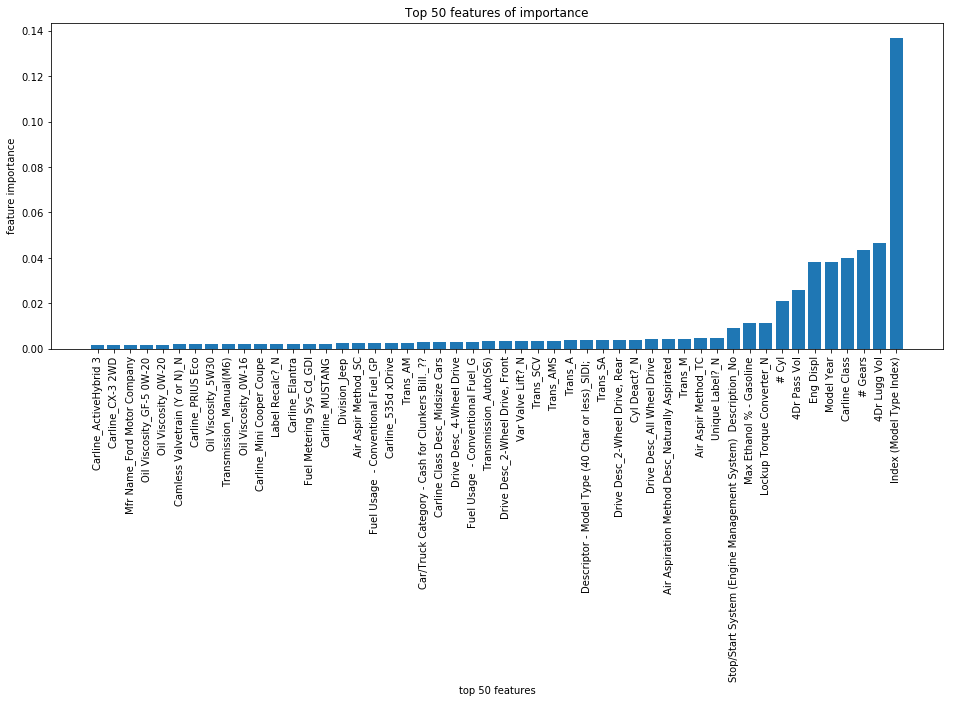

In [11]:
feature_importance=xgb.feature_importances_
num_feature=50
gbindices=np.argsort(feature_importance)[-num_feature:]
features_list=df3_train.columns
chosen_feature=[]
for i in gbindices:
    chosen_feature.append(features_list[i])
fig=plt.figure(figsize=(16,6))
plt.bar(range(num_feature),feature_importance[gbindices])
plt.xticks(range(num_feature),chosen_feature,rotation=90)
plt.ylabel('feature importance')
plt.xlabel('top %d features'%num_feature)
plt.title('Top %d features of importance' %num_feature)
plt.show()

In [12]:
dup_col=['Drive Sys','Fuel Metering Sys Desc','Fuel Unit Desc - Conventional Fuel','Fuel Usage Desc - Conventional Fuel','Mfr Name',\
'Stop/Start System (Engine Management System)  Description','Trans Desc']

In [13]:
df4=df1.drop(dup_col,axis=1)
df4_d=pd.get_dummies(df4)
X_train,X_test,y_train,y_test=train_test_split(df4_d.drop('target',axis=1),df4_d['target'],random_state=5,test_size=0.4)

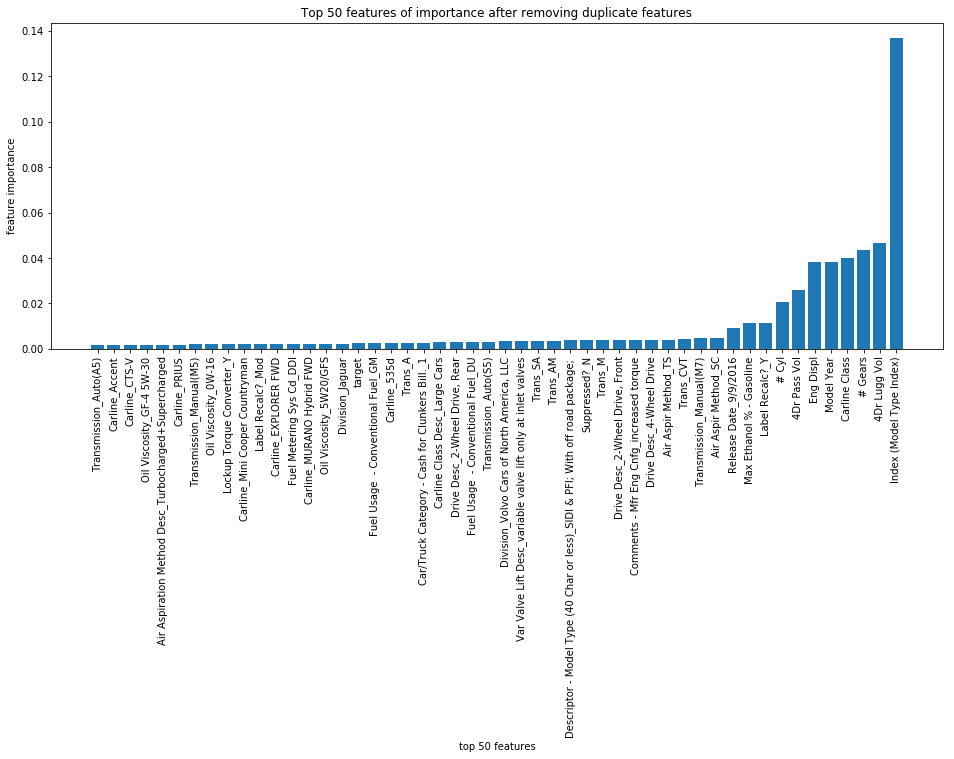

In [14]:
xgb=XGBRegressor(learning_rate=0.01,max_depth=max_depth,n_estimators=n_estimators,n_jobs=5).fit(X_train,y_train)
feature_importance=xgb.feature_importances_
num_feature=50
gbindices=np.argsort(feature_importance)[-num_feature:]
features_list=df4_d.columns
chosen_feature=[]
for i in gbindices:
    chosen_feature.append(features_list[i])
fig=plt.figure(figsize=(16,6))
plt.bar(range(num_feature),feature_importance[gbindices])
plt.xticks(range(num_feature),chosen_feature,rotation=90)
plt.title('Top %d features of importance after removing duplicate features' %num_feature)
plt.ylabel('feature importance')
plt.xlabel('top %d features'%num_feature)
plt.show()

## Feature Selection & Results Description

* The two graphs shown above are the top 50 features of importance before and after removing the duplicate features. As we can see, the models before and after removing duplicates both agree that `'Index (Model Type Index)'` is the most important (influential) feature. The Top 5 most important features also agree (`'Index (Model Type Index)','4Dr Lugg Vol','# Gears','Carline Class','Model Year'`).

* After observation, we see these as duplicate features:
 `'Drive Sys','Fuel Metering Sys Desc','Fuel Unit Desc - Conventional Fuel','Fuel Usage Desc - Conventional Fuel','Mfr Name','Stop/Start System (Engine Management System)  Description','Trans Desc'`.
 After removing those features, we calculated the scores for both 2018 prediction and with iid assumption. The scores are almost the same as before (0.97258 for 2018 prediction and 0.97966 for iid assumption). This implies that these features could be removed basically without any influence  in performance.
 
* At last, we applied `SelectFromModel` to do the model selection using `RandomForestRegression` with the threshold od 1e-4. 
 After removing those irrelevant features using that standard, we calculated the scores for both 2018 prediction and with iid assumption. The scores improved after droping irrelevant features (0.97259 before dropping and 0.97293 after for predicting 2018 data; 0.97966 before dropping and 0.98262 after with iid assumption). This implies that if we use `RandomForestRegression` with the threshold od 1e-4 to choose the features, the prediction results will get better.
 
* After removing the irrelevant features, the top 5 important features still remain the same, but it seems that this time the model is putting more emphisis on the top several important features.

## Prediction of 2018 after removing the duplicate features

In [15]:
df4_train=df4_d[df1['Model Year']!=2018].drop('target',axis=1)
train_target4=df4_d[df1['Model Year']!=2018]['target']
df4_test=df4_d[df1['Model Year']==2018].drop('target',axis=1)
test_target4=df4_d[df1['Model Year']==2018]['target']

In [16]:
xgb_pred2018=XGBRegressor(learning_rate=0.01,max_depth=max_depth,n_estimators=n_estimators,n_jobs=5).fit(df4_train,train_target4)
score_pred2018=xgb_pred2018.score(df4_test,test_target4)
print('Prediction score for 2018 after removing duplicate features is %.5f' %score_pred2018)

Prediction score for 2018 after removing duplicate features is 0.97258


## Train and Test with iid assumption after removing the duplicates

In [17]:
X_train,X_test,y_train,y_test=train_test_split(df4_d.drop('target',axis=1),df4_d['target'],random_state=5,test_size=0.4)
xgb_test=XGBRegressor(learning_rate=0.01,max_depth=max_depth,n_estimators=n_estimators,n_jobs=5).fit(X_train,y_train)
score_test=xgb_test.score(X_test,y_test)
print('Score with iid assumption is %.5f after removing the duplicates' %score_test)

Score with iid assumption is 0.97966 after removing the duplicates


## Prediction of 2018 after removing irrelevant features

In [18]:
pipe_select=make_pipeline(Imputer(strategy='mean'),SelectFromModel(RandomForestRegressor(n_estimators=300,oob_score=True),threshold=1e-4))
pipe_select.fit(df4_train,train_target4)
df4_select_train=pipe_select.transform(df4_train)
df4_select_test=pipe_select.transform(df4_test)

In [19]:
xgb_pred2018=XGBRegressor(learning_rate=0.01,max_depth=max_depth,n_estimators=n_estimators,n_jobs=5).fit(df4_select_train,train_target4)
score_pred2018=xgb_pred2018.score(df4_select_test,test_target4)
print('Prediction score for 2018 after removing irrelevant features is %.5f' %score_pred2018)

Prediction score for 2018 after removing irrelevant features is 0.97293


## Train and Test with iid assumption after removing the irrelevant

In [20]:
X_train,X_test,y_train,y_test=train_test_split(df4_d.drop('target',axis=1),df4_d['target'],random_state=5,test_size=0.4)
pipe_select.fit(X_train,y_train)
x_train=pipe_select.transform(X_train)
x_test=pipe_select.transform(X_test)
xgb_rem_irr=XGBRegressor(learning_rate=0.01,max_depth=max_depth,n_estimators=n_estimators,n_jobs=5).fit(x_train,y_train)
score_test=xgb_rem_irr.score(x_test,y_test)
print('Score with iid assumption is %.5f after removing the irrelevant' %score_test)

Score with iid assumption is 0.98262 after removing the irrelevant


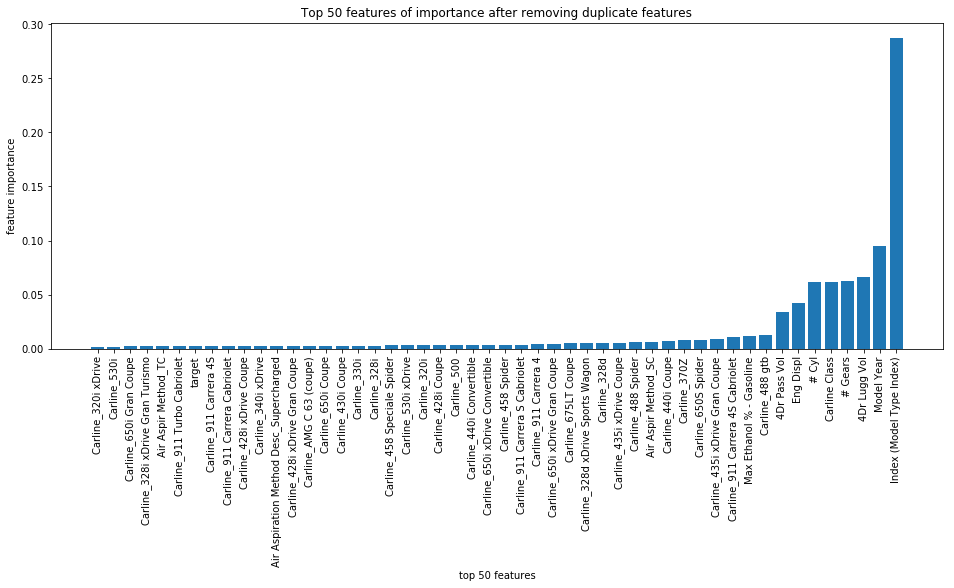

In [21]:
feature_importance=xgb_rem_irr.feature_importances_
num_feature=50
gbindices=np.argsort(feature_importance)[-num_feature:]
features_list=df4_d.columns
chosen_feature=[]
for i in gbindices:
    chosen_feature.append(features_list[i])
fig=plt.figure(figsize=(16,6))
plt.bar(range(num_feature),feature_importance[gbindices])
plt.xticks(range(num_feature),chosen_feature,rotation=90)
plt.title('Top %d features of importance after removing duplicate features' %num_feature)
plt.ylabel('feature importance')
plt.xlabel('top %d features'%num_feature)
plt.show()